In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import keras_tuner as kt

sns.set(style="whitegrid")


In [2]:
# Load all weather data files
temperature_df = pd.read_csv(r'C:\Users\HP\OneDrive\Desktop\WEATHER PREDICTION PROJECT\temperature.csv')
humidity_df = pd.read_csv(r'C:\Users\HP\OneDrive\Desktop\WEATHER PREDICTION PROJECT\humidity.csv')
pressure_df = pd.read_csv(r'C:\Users\HP\OneDrive\Desktop\WEATHER PREDICTION PROJECT\pressure.csv')
wind_speed_df = pd.read_csv(r'C:\Users\HP\OneDrive\Desktop\WEATHER PREDICTION PROJECT\wind_speed.csv')
wind_direction_df = pd.read_csv(r'C:\Users\HP\OneDrive\Desktop\WEATHER PREDICTION PROJECT\wind_direction.csv')
weather_description_df = pd.read_csv(r'C:\Users\HP\OneDrive\Desktop\WEATHER PREDICTION PROJECT\weather_description.csv')

# Display the first few rows of each DataFrame to understand their structure
dataframes = [temperature_df, humidity_df, pressure_df, wind_speed_df, wind_direction_df, weather_description_df]
names = ["Temperature", "Humidity", "Pressure", "Wind Speed", "Wind Direction", "Weather Description"]

for df, name in zip(dataframes, names):
    print(f"\n{name} Data:")
    print(df.head())



Temperature Data:
              datetime   Vancouver    Portland  San Francisco     Seattle  \
0  2012-10-01 12:00:00         NaN         NaN            NaN         NaN   
1  2012-10-01 13:00:00  284.630000  282.080000     289.480000  281.800000   
2  2012-10-01 14:00:00  284.629041  282.083252     289.474993  281.797217   
3  2012-10-01 15:00:00  284.626998  282.091866     289.460618  281.789833   
4  2012-10-01 16:00:00  284.624955  282.100481     289.446243  281.782449   

   Los Angeles   San Diego   Las Vegas     Phoenix  Albuquerque  ...  \
0          NaN         NaN         NaN         NaN          NaN  ...   
1   291.870000  291.530000  293.410000  296.600000   285.120000  ...   
2   291.868186  291.533501  293.403141  296.608509   285.154558  ...   
3   291.862844  291.543355  293.392177  296.631487   285.233952  ...   
4   291.857503  291.553209  293.381213  296.654466   285.313345  ...   

   Philadelphia    New York    Montreal      Boston   Beersheba  \
0           NaN   

In [4]:
# Fill missing values for each DataFrame using both forward and backward fill
for df in dataframes:
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

# Check missing values after filling
for df, name in zip(dataframes, names):
    print(f"\n{name} Data Missing Values After Filling:")
    print(df.isnull().sum())


C:\Users\HP\AppData\Local\Temp/ipykernel_32196/590381424.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\HP\AppData\Local\Temp/ipykernel_32196/590381424.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)



Temperature Data Missing Values After Filling:
datetime             0
Vancouver            0
Portland             0
San Francisco        0
Seattle              0
Los Angeles          0
San Diego            0
Las Vegas            0
Phoenix              0
Albuquerque          0
Denver               0
San Antonio          0
Dallas               0
Houston              0
Kansas City          0
Minneapolis          0
Saint Louis          0
Chicago              0
Nashville            0
Indianapolis         0
Atlanta              0
Detroit              0
Jacksonville         0
Charlotte            0
Miami                0
Pittsburgh           0
Toronto              0
Philadelphia         0
New York             0
Montreal             0
Boston               0
Beersheba            0
Tel Aviv District    0
Eilat                0
Haifa                0
Nahariyya            0
Jerusalem            0
dtype: int64

Humidity Data Missing Values After Filling:
datetime             0
Vancouver           

In [5]:
# Function to create a 'datetime' column assuming hourly intervals from a start date
def add_datetime_column(df, start_date='2020-01-01', freq='H'):
    date_range = pd.date_range(start=start_date, periods=len(df), freq=freq)
    df['datetime'] = date_range

# Apply this function to each DataFrame
for df in dataframes:
    add_datetime_column(df)

# Set 'datetime' as the index for all dataframes
for df in dataframes:
    df.set_index('datetime', inplace=True)

# Ensure unique column names for merging
suffixes = ["_temp", "_humidity", "_pressure", "_windspeed", "_winddir", "_weatherdesc"]
for df, suffix in zip(dataframes, suffixes):
    df.columns = [f"{col}{suffix}" if col != 'datetime' else col for col in df.columns]

# Perform an outer merge to keep all timestamps from all datasets
from functools import reduce
combined_df = reduce(lambda left, right: pd.merge(left, right, on='datetime', how='outer'), dataframes)

# Display the head of the combined dataframe to check the merge
print(combined_df.head())

# Display summary of missing values after merging
print("\nCombined DataFrame Missing Values After Merging:")
print(combined_df.isnull().sum())


C:\Users\HP\AppData\Local\Temp/ipykernel_32196/2529698173.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(start=start_date, periods=len(df), freq=freq)


                     Vancouver_temp  Portland_temp  San Francisco_temp  \
datetime                                                                 
2020-01-01 00:00:00      284.630000     282.080000          289.480000   
2020-01-01 01:00:00      284.630000     282.080000          289.480000   
2020-01-01 02:00:00      284.629041     282.083252          289.474993   
2020-01-01 03:00:00      284.626998     282.091866          289.460618   
2020-01-01 04:00:00      284.624955     282.100481          289.446243   

                     Seattle_temp  Los Angeles_temp  San Diego_temp  \
datetime                                                              
2020-01-01 00:00:00    281.800000        291.870000      291.530000   
2020-01-01 01:00:00    281.800000        291.870000      291.530000   
2020-01-01 02:00:00    281.797217        291.868186      291.533501   
2020-01-01 03:00:00    281.789833        291.862844      291.543355   
2020-01-01 04:00:00    281.782449        291.857503    

In [18]:
# Drop non-numeric columns explicitly
columns_to_drop = [col for col in combined_df.columns if '_weatherdesc' in col]
numeric_df = combined_df.drop(columns=columns_to_drop, axis=1)

# Convert all columns to float, handling errors by coercing to NaN
numeric_df = numeric_df.apply(pd.to_numeric, errors='coerce')

# Identify and display columns with NaN values
nan_columns = numeric_df.columns[numeric_df.isna().any()].tolist()
print("Columns with NaN values before cleaning:", nan_columns)
print(numeric_df[nan_columns].isna().sum())

# Apply forward fill and backward fill to handle NaNs
numeric_df.fillna(method='ffill', inplace=True)
numeric_df.fillna(method='bfill', inplace=True)

# Recheck and handle remaining NaNs with mean imputation as a fallback
if numeric_df.isnull().any().any():
    numeric_df.fillna(numeric_df.mean(), inplace=True)

# Ensure there are no infinite values
numeric_df.replace([np.inf, -np.inf], np.nan, inplace=True)
numeric_df.fillna(method='ffill', inplace=True)
numeric_df.fillna(method='bfill', inplace=True)

# Final check for NaN or infinite values in numeric_df
if numeric_df.isnull().any().any() or np.isinf(numeric_df).any().any():
    print("Data still contains NaN or Infinite values after all handling.")

# Initialize the scaler and scale the numeric data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(numeric_df)

# List all columns to identify the correct target column name
print("Columns in numeric_df:", numeric_df.columns)

# Use the correct target column name for New York's temperature data
target_column = 'New York_temp'  # Correct column name
if target_column in numeric_df.columns:
    target_index = numeric_df.columns.get_loc(target_column)
    target = scaled_features[:, target_index]
else:
    raise ValueError(f"{target_column} is not in DataFrame columns.")

# Final check for NaN or infinite values in scaled features and target
if np.isnan(scaled_features).any() or np.isnan(target).any():
    raise ValueError("Data still contains NaN values after all handling.")
if np.isinf(scaled_features).any() or np.isinf(target).any():
    raise ValueError("Data still contains Infinite values after all handling.")

# Confirm the shapes and data integrity before proceeding to the model
print("Final check - Scaled features shape:", scaled_features.shape)
print("Final check - Target shape:", target.shape)


Columns with NaN values before cleaning: []
Series([], dtype: float64)
Columns in numeric_df: Index(['Vancouver_temp', 'Portland_temp', 'San Francisco_temp', 'Seattle_temp',
       'Los Angeles_temp', 'San Diego_temp', 'Las Vegas_temp', 'Phoenix_temp',
       'Albuquerque_temp', 'Denver_temp',
       ...
       'Philadelphia_winddir', 'New York_winddir', 'Montreal_winddir',
       'Boston_winddir', 'Beersheba_winddir', 'Tel Aviv District_winddir',
       'Eilat_winddir', 'Haifa_winddir', 'Nahariyya_winddir',
       'Jerusalem_winddir'],
      dtype='object', length=180)
Final check - Scaled features shape: (45253, 180)
Final check - Target shape: (45253,)


C:\Users\HP\AppData\Local\Temp/ipykernel_32196/3377424381.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  numeric_df.fillna(method='ffill', inplace=True)
C:\Users\HP\AppData\Local\Temp/ipykernel_32196/3377424381.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  numeric_df.fillna(method='bfill', inplace=True)
C:\Users\HP\AppData\Local\Temp/ipykernel_32196/3377424381.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  numeric_df.fillna(method='ffill', inplace=True)
C:\Users\HP\AppData\Local\Temp/ipykernel_32196/3377424381.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  numeric_df.fillna(method='bfill', inplace=Tr

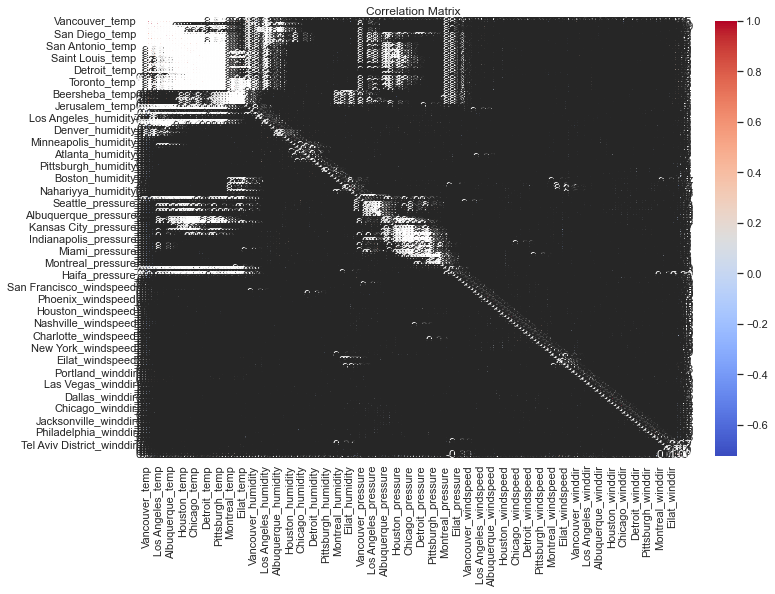

In [19]:
# Finding Correlations
correlation_matrix = numeric_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [20]:
# Define look_back and batch size for TimeseriesGenerator
look_back = 24  # Number of past hours to use for prediction
batch_size = 32

# Generate time series batches
train_size = int(len(scaled_features) * 0.8)
train_generator = TimeseriesGenerator(scaled_features, target,
                                      length=look_back, batch_size=batch_size,
                                      end_index=train_size - 1)
test_generator = TimeseriesGenerator(scaled_features, target,
                                     length=look_back, batch_size=batch_size,
                                     start_index=train_size)


In [21]:
# Define a function for creating a model, for use in hyperparameter tuning
def build_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('units', min_value=32, max_value=512, step=32), input_shape=(look_back, scaled_features.shape[1]), return_sequences=True))
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(LSTM(hp.Int('units', min_value=32, max_value=512, step=32), return_sequences=False))
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(1))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='mean_squared_error',
                  metrics=['mae'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='lstm_hyperparameter_tuning'
)

tuner.search(train_generator, epochs=10, validation_data=test_generator)


Trial 5 Complete [03h 54m 45s]
val_loss: 0.0012251194178437193

Best val_loss So Far: 0.0012251194178437193
Total elapsed time: 08h 07m 03s


In [22]:
# Build the LSTM model
model = Sequential([
    LSTM(50, input_shape=(look_back, scaled_features.shape[1]), return_sequences=True),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

# Compile the model with a smaller learning rate
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Display the model summary to check the architecture
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 24, 50)         │        46,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,451 (259.57 KB)

 Trainable params: 66,451 (259.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 0.0776 - mae: 0.1741 - val_loss: 0.0035 - val_mae: 0.0467
Epoch 2/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0091 - mae: 0.0759 - val_loss: 0.0028 - val_mae: 0.0416
Epoch 3/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.0068 - mae: 0.0655 - val_loss: 0.0024 - val_mae: 0.0387
Epoch 4/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.0056 - mae: 0.0592 - val_loss: 0.0026 - val_mae: 0.0397
Epoch 5/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - loss: 0.0051 - mae: 0.0565 - val_loss: 0.0021 - val_mae: 0.0353
Epoch 6/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 0.0046 - mae: 0.0538 - val_loss: 0.0030 - val_mae: 0.0444
Epoch 7/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - loss: 0.0044 - mae: 0.0522 - val_loss: 0.0018 - val_mae: 0.0327
Epoch 8/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 26s 23ms/step - loss: 0.0040 - mae: 0.0496 - val_loss: 0.0018 - val_mae: 0.0324
Epoch 9/20
1131/1131 ━━━

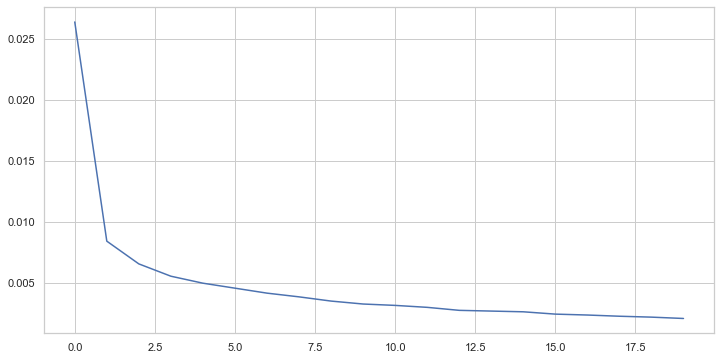

In [23]:
# Fit the model on the training data
history = model.fit(train_generator, epochs=20, validation_data=test_generator, verbose=1)

# Plot the training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')


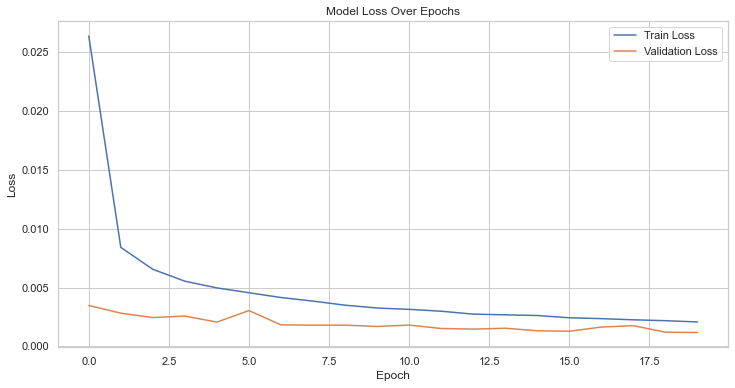

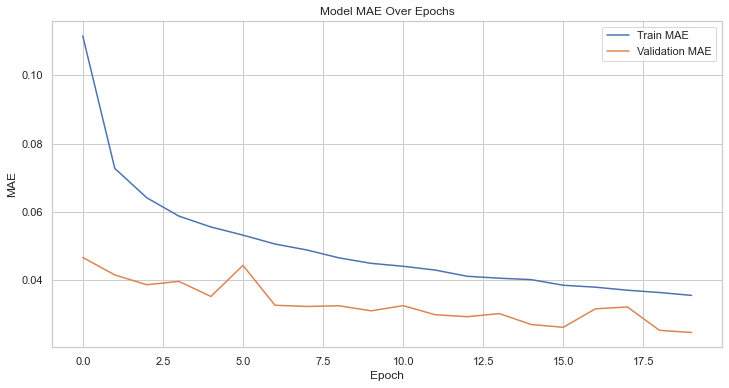

In [24]:
# Plot the training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot the MAE history
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE Over Epochs')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [25]:
# Evaluate the model's performance on the test set
test_metrics = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_metrics[0]}, Test MAE: {test_metrics[1]}")


283/283 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 7.2460e-04 - mae: 0.0210
Test Loss: 0.0011815371690317988, Test MAE: 0.024766769260168076


283/283 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
R^2 Score: 0.9523344993870244


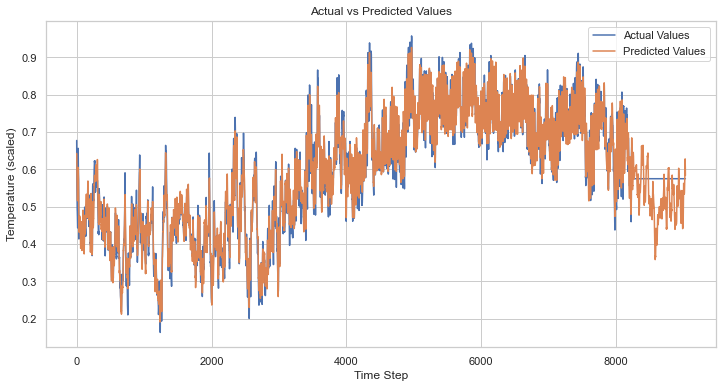

In [26]:
from sklearn.metrics import r2_score

# Make predictions
predictions = model.predict(test_generator)

# Compare predictions to actual values
predicted_values = predictions.flatten()
actual_values = target[-len(predicted_values):]

# Calculate the R^2 score
r2 = r2_score(actual_values, predicted_values)
print(f"R^2 Score: {r2}")

# Plot the predictions against the actual values
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label='Actual Values')
plt.plot(predicted_values, label='Predicted Values')
plt.title('Actual vs Predicted Values')
plt.ylabel('Temperature (scaled)')
plt.xlabel('Time Step')
plt.legend()
plt.show()

